# Final Model (with dataset 02)

In [1]:
import pandas as pd

df = pd.read_csv('images_4.csv')
df

,image,label
0,ea7b6656-3f84-4eb3-9099-23e623fc1018,T-Shirt
1,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,T-Shirt
2,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,Shoes
3,5d3a1404-697f-479f-9090-c1ecd0413d27,Shorts
4,b0c03127-9dfb-4573-8934-1958396937bf,Shirt
...,...,...
5265,female-casual-peach-color-jeans-female-casual-...,Pants
5266,lilac-jeans-wooden-background-lilac-jeans-wood...,Pants
5267,jeans-image-table-48097904,Pants
5268,jeans-white-background-classical-isolated-clos...,Pants


In [2]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
labels = le.fit_transform(df.label)
labels

array([13, 13, 10, ...,  7,  7,  7])

In [3]:
images = df.iloc[:, 0]

## Split data into train and validation using stratified shuffle split

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit

ss = StratifiedShuffleSplit(n_splits=1, test_size=0.1)
for _, group_index in ss.split(images, labels):
    group_x = images[group_index].to_numpy()
    group_y = labels[group_index]

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit

ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_index, test_index in ss.split(images, labels):
    train_x, test_x = images[train_index].to_numpy(), images[test_index].to_numpy()
    train_y, test_y = labels[train_index], labels[test_index]

In [6]:
ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_index, valid_index in ss.split(train_x, train_y):
    train_x, valid_x = train_x[train_index], train_x[valid_index]
    train_y, valid_y = train_y[train_index], train_y[valid_index]

## Get all images loaded in from sample and convert to tensor

In [7]:
import numpy as np
from skimage.io import imread
from skimage.transform import resize

def get_images(path_list):
    train_img = []
    for filename in path_list:
        path = 'images_compressed/' + filename + '.jpg'
        img = imread(path, as_gray=True)
        img = resize(img, (100, 100))
        img /= 255.0
        img = img.astype('float32')
        train_img.append(img)
    return np.asarray(train_img)

In [8]:
train_x_images = get_images(train_x)

In [9]:
train_x_images.shape

(3372, 100, 100)

In [10]:
valid_x_images = get_images(valid_x)
test_x_images = get_images(test_x)

In [11]:
import torch

train_x_torch = torch.from_numpy(train_x_images).unsqueeze(dim=1)
valid_x_torch = torch.from_numpy(valid_x_images).unsqueeze(dim=1)
test_x_torch = torch.from_numpy(test_x_images).unsqueeze(dim=1)

In [12]:
train_x_torch.shape

torch.Size([3372, 1, 100, 100])

In [13]:
train_y_torch = torch.from_numpy(train_y)
valid_y_torch = torch.from_numpy(valid_y)
test_y_torch = torch.from_numpy(test_y)
train_y_torch.shape

torch.Size([3372])

## Use gpu if available

In [14]:
if torch.cuda.is_available():
    train_x_torch = train_x_torch.cuda()
    train_y_torch = train_y_torch.cuda()
    valid_x_torch = valid_x_torch.cuda()
    valid_y_torch = valid_y_torch.cuda()
    test_x_torch = test_x_torch.cuda()
    test_y_torch = test_y_torch.cuda()
    

In [15]:
train = list(zip(train_x_torch, train_y_torch.to(dtype=torch.long)))
test = list(zip(test_x_torch, test_y_torch.to(dtype=torch.long)))
valid = list(zip(valid_x_torch, valid_y_torch.to(dtype=torch.long)))

In [16]:
# put everything into a data loader because too much data for gpu

from torch.utils.data import DataLoader

trainloader = DataLoader(train, batch_size=16)
testloader = DataLoader(test, batch_size=16)
validloader = DataLoader(valid, batch_size=16)

## Create CNN model

In [86]:
from torch import nn

class ConvNN(nn.Module):
    def __init__(self):
        super(ConvNN, self).__init__()
        
        self.cnn_layers = nn.Sequential (
            # Conv 1
            nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=2),   # output = 100 x 100 x 512              
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),  
            nn.MaxPool2d(kernel_size=2, stride=2),                   # 50 x 50 x 512
            nn.Dropout(),
            # Conv 2
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),  
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),                                   
            nn.MaxPool2d(kernel_size=2, stride=2),                   # 25 X 25 X 512
            nn.Dropout(),
            # Conv 3
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(inplace=True),  
            nn.BatchNorm2d(256),                                    
            nn.MaxPool2d(kernel_size=2, stride=2),                   # 12 X 12 X 512
            nn.Dropout(),
            # Conv 4
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),                                    
            nn.MaxPool2d(kernel_size=2, stride=2),                   # 6 X 6 X 512
            nn.Dropout()
        )
        
        self.linear_layers = nn.Sequential(
            nn.Linear(512 * 6 * 6, 15)
        )
        
    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [87]:
from torch import optim

model = ConvNN()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

ConvNN(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.5, inplace=False)
    (5): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (6): ReLU(inplace=True)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.5, inplace=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout(p=0.5, inplace=False)
    (15): 

## Train and collect performance metrics over 100 epochs

In [88]:
train_losses = []
valid_losses = []
ALLOWED_DROPS = 3
drops = ALLOWED_DROPS # how many times would the validation accuracy fall before pulling the plug
train_acc = []
valid_acc = [0]


epochs = 100
for epoch in range(epochs):
    train_loss = 0.
    valid_loss = 0.
    train_correct = 0
    train_total = 0
    valid_correct = 0
    valid_total = 0
    
    model.train()
    for images, labels in trainloader:
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        for i in range(len(labels)):
            image = images[i].view(1, 1, 100, 100)
            with torch.no_grad():
                logps = model(image)
            allprobs = torch.exp(logps)
            prob = allprobs.tolist()[0]
            hyp = prob.index(max(prob))
            train_y = labels[i]
            train_total += 1
            if train_y.item() == hyp:
                train_correct += 1
                
    train_losses.append(train_loss/len(trainloader))
    
    model.eval()
    for images, labels in validloader:
        output = model(images)
        loss = criterion(output, labels)
        valid_loss += loss.item()
        for i in range(len(labels)):
            image = images[i].view(1, 1, 100, 100)
            with torch.no_grad():
                logps = model(image)
            allprobs = torch.exp(logps)
            prob = allprobs.tolist()[0]
            hyp = prob.index(max(prob))
            valid_y = labels[i]
            valid_total += 1
            if valid_y.item() == hyp:
                valid_correct += 1
                
    valid_losses.append(valid_loss/len(validloader))
    train_acc.append(train_correct/train_total)
    valid_acc.append(valid_correct/valid_total)
    
    print('At epoch', epoch, 'loss =', '%.3g'%(train_loss/len(trainloader)), 'train acc=', '%.3g'%(train_correct/train_total), 'valid loss =', '%.3g'%(valid_loss/len(validloader)), 'valid acc =', '%.3g'%(valid_correct/valid_total))
    
    if valid_acc[-1] <= valid_acc[-2]:
        drops -= 1
        if drops == 0:
            print('Terminating early!')
            break
    else:
        drops = ALLOWED_DROPS

At epoch 0 loss = 2.75 train acc= 0.257 valid loss = 2.16 valid acc = 0.347
At epoch 1 loss = 2.34 train acc= 0.335 valid loss = 1.99 valid acc = 0.434
At epoch 2 loss = 2.03 train acc= 0.396 valid loss = 1.86 valid acc = 0.48
At epoch 3 loss = 1.79 train acc= 0.453 valid loss = 1.92 valid acc = 0.5
At epoch 4 loss = 1.64 train acc= 0.482 valid loss = 1.86 valid acc = 0.512
At epoch 5 loss = 1.52 train acc= 0.504 valid loss = 2 valid acc = 0.499
At epoch 6 loss = 1.43 train acc= 0.525 valid loss = 2.11 valid acc = 0.494
At epoch 7 loss = 1.32 train acc= 0.544 valid loss = 2.1 valid acc = 0.512
At epoch 8 loss = 1.19 train acc= 0.558 valid loss = 2.28 valid acc = 0.501
At epoch 9 loss = 1.11 train acc= 0.59 valid loss = 2.4 valid acc = 0.502
At epoch 10 loss = 1.07 train acc= 0.593 valid loss = 2.36 valid acc = 0.531
At epoch 11 loss = 1.01 train acc= 0.611 valid loss = 2.32 valid acc = 0.545
At epoch 12 loss = 0.908 train acc= 0.63 valid loss = 2.39 valid acc = 0.538
At epoch 13 loss =

In [76]:
correct = 0.
total = 0.

hyps = []
correct_labels = []

for images, labels in testloader:
    for i in range(len(labels)):
        image = images[i].view(1, 1, 100, 100)
        with torch.no_grad():
            logps = model(image)
        allprobs = torch.exp(logps)
        prob = allprobs.tolist()[0]
        hyp = prob.index(max(prob))
        hyps.append(hyp)
        test_y = labels[i]
        total += 1
        correct_labels.append(test_y.item())
        if test_y.item() == hyp:
            correct += 1

print(correct/total)

0.6612903225806451


## 69% accuracy

In [70]:
from sklearn.metrics import classification_report

print(classification_report(correct_labels, hyps, target_names=['Blazer', 'Blouse', 'Dress', 'Hat', 'Hoodie', 'Longsleeve',
       'Outwear', 'Pants', 'Polo', 'Shirt', 'Shoes', 'Shorts', 'Skirt',
       'T-Shirt', 'Undershirt']))

              precision    recall  f1-score   support

      Blazer       0.62      0.23      0.33        22
      Blouse       0.00      0.00      0.00         5
       Dress       0.62      0.63      0.63        71
         Hat       0.62      0.44      0.52        34
      Hoodie       0.62      0.25      0.36        20
  Longsleeve       0.71      0.61      0.65       140
     Outwear       0.57      0.53      0.55        62
       Pants       0.84      0.89      0.86       159
        Polo       0.58      0.29      0.39        24
       Shirt       0.49      0.73      0.59       113
       Shoes       0.82      0.83      0.82        86
      Shorts       0.76      0.68      0.72        62
       Skirt       0.75      0.29      0.42        31
     T-Shirt       0.74      0.89      0.81       202
  Undershirt       0.62      0.43      0.51        23

    accuracy                           0.69      1054
   macro avg       0.62      0.51      0.54      1054
weighted avg       0.70   

## Examine change in loss/accuracy over time

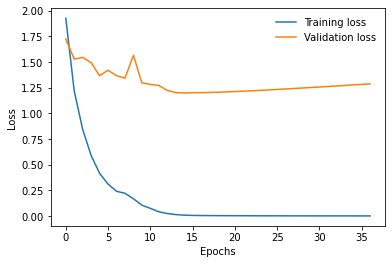

In [71]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

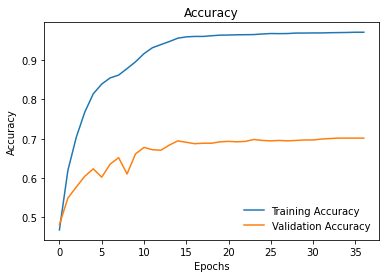

In [72]:
plt.plot(train_acc, label='Training Accuracy')
plt.plot(valid_acc[1:], label='Validation Accuracy')
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(frameon=False)